In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import BallTree
from sklearn.metrics import (
    mean_squared_error,
    roc_auc_score,
    r2_score,
)

import holidays

DATA_DIR = Path('../shared_data/')  # change to your local path
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# ---- 1.1 Load wildfires ----
fires_path = DATA_DIR / 'wildfires_fires.parquet'

fires = pd.read_parquet(
    fires_path,
    columns=[
        'FIRE_SIZE',
        'DISCOVERY_DATE',
        'STATE',
        'STAT_CAUSE_CODE',
        'LATITUDE',
        'LONGITUDE',
    ],
)

# Convert DISCOVERY_DATE to datetime
if not np.issubdtype(fires['DISCOVERY_DATE'].dtype, np.datetime64):
    fires['DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'])

fires = fires.rename(columns={'DISCOVERY_DATE': 'date'})

# Filter date range 1992–2015
fires = fires[
    (fires['date'].dt.year >= 1992) & (fires['date'].dt.year <= 2015)
]

# Drop rows without coordinates
fires = fires.dropna(subset=['LATITUDE', 'LONGITUDE'])
fires.head()

,FIRE_SIZE,date,STATE,STAT_CAUSE_CODE,LATITUDE,LONGITUDE
0,0.10,2005-02-02,CA,9.0,40.036944,-121.005833
1,0.25,2004-05-12,CA,1.0,38.933056,-120.404444
2,0.10,2004-05-31,CA,5.0,38.984167,-120.735556
3,0.10,2004-06-28,CA,1.0,38.559167,-119.913333
4,0.10,2004-06-28,CA,1.0,38.559167,-119.933056


# 0. Exploratory data analysis (EDA)


In this section we explore the raw wildfire and station-mapped data before building models.


We focus on:

- The distribution of distances from each fire to its nearest weather station.

- The distribution of burned area per fire (on both raw and log scales).

- Basic counts per state and over time.


The log-fire size has a bit of an erratic distribution, the spikes are likely due to rounding. We should explore this further


In [3]:
# ---- 1.1b Attach closest weather station to each fire ----
cities_path = DATA_DIR / 'cities.csv'
stations = pd.read_csv(cities_path)

# Keep one row per station with coordinates
stations = stations[["station_id", "latitude", "longitude"]].drop_duplicates('station_id')

# Build BallTree (coordinates in radians)
station_coords = np.radians(stations[['latitude', 'longitude']].values)
fire_coords = np.radians(fires[['LATITUDE', 'LONGITUDE']].values)

tree = BallTree(station_coords, metric='haversine')
dist_rad, ind = tree.query(fire_coords, k=1)

fires['station_id'] = stations.iloc[ind.flatten()]['station_id'].values
fires['dist_to_station_km'] = dist_rad.flatten() * 6371.0  # earth radius ~6371 km

fires.head()

,FIRE_SIZE,date,STATE,STAT_CAUSE_CODE,LATITUDE,LONGITUDE,station_id,dist_to_station_km
0,0.10,2005-02-02,CA,9.0,40.036944,-121.005833,72488,143.878212
1,0.25,2004-05-12,CA,1.0,38.933056,-120.404444,72488,60.782146
2,0.10,2004-05-31,CA,5.0,38.984167,-120.735556,72483,78.251133
3,0.10,2004-06-28,CA,1.0,38.559167,-119.913333,72488,68.430576
4,0.10,2004-06-28,CA,1.0,38.559167,-119.933056,72488,68.768514


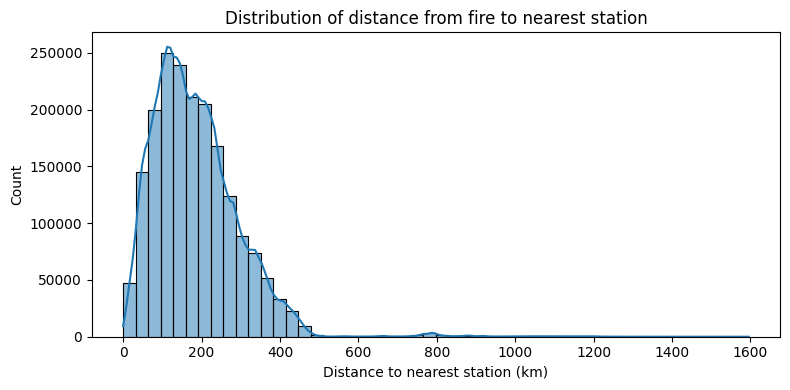

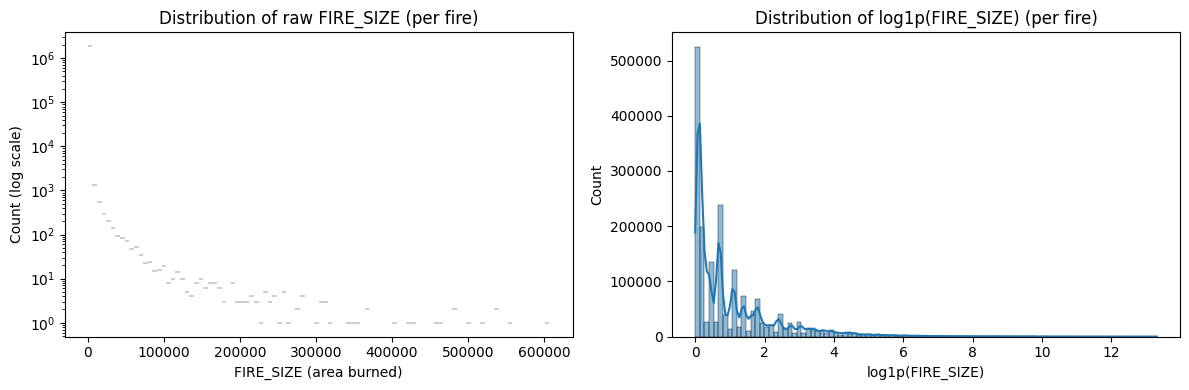

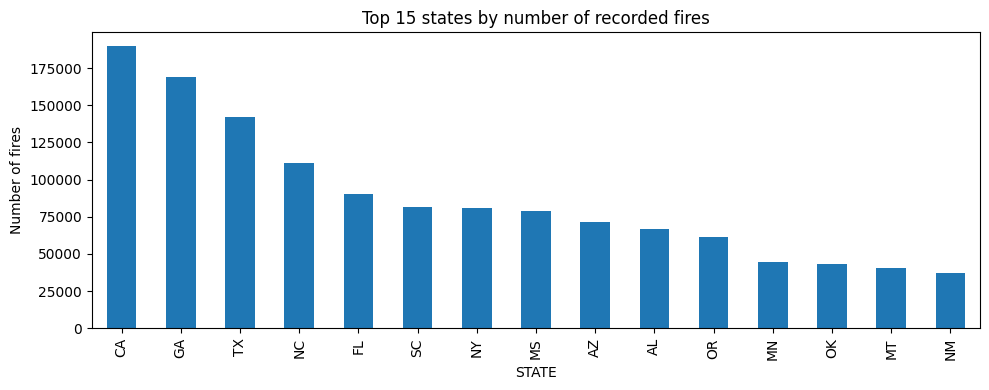

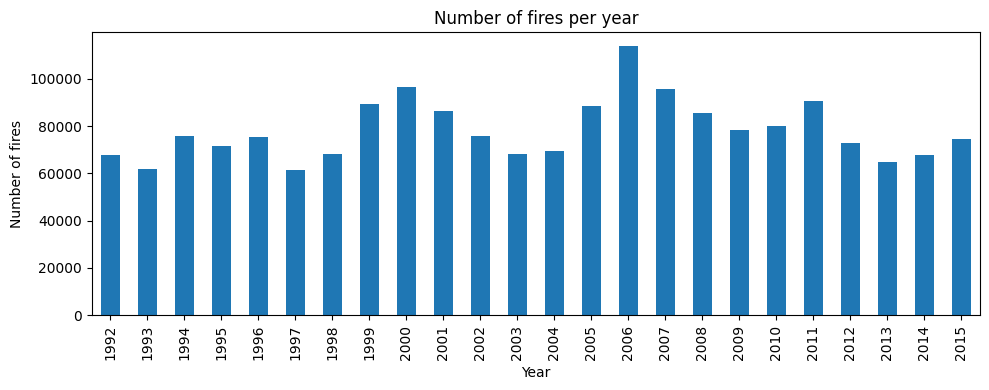

In [4]:
# ---- 0.1 EDA: distance to nearest station and burned area ----
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we have the station distance in km (computed in the previous cell)
assert 'dist_to_station_km' in fires.columns, 'dist_to_station_km missing; run the station mapping cell first.'

# Distribution of distance to nearest station
plt.figure(figsize=(8, 4))
sns.histplot(fires['dist_to_station_km'], bins=50, kde=True)
plt.xlabel('Distance to nearest station (km)')
plt.title('Distribution of distance from fire to nearest station')
plt.tight_layout()
plt.show()

# Raw area burned per fire
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(fires['FIRE_SIZE'], bins=100, log_scale=(False, True))
plt.xlabel('FIRE_SIZE (area burned)')
plt.ylabel('Count (log scale)')
plt.title('Distribution of raw FIRE_SIZE (per fire)')

# Log-transformed area per fire
plt.subplot(1, 2, 2)
log_fire_size = np.log1p(fires['FIRE_SIZE'])
sns.histplot(log_fire_size, bins=100, kde=True)
plt.xlabel('log1p(FIRE_SIZE)')
plt.title('Distribution of log1p(FIRE_SIZE) (per fire)')

plt.tight_layout()
plt.show()

# EDA: simple counts per state and over time
plt.figure(figsize=(10, 4))
fires['STATE'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 states by number of recorded fires')
plt.xlabel('STATE')
plt.ylabel('Number of fires')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
fires['date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Number of fires per year')
plt.xlabel('Year')
plt.ylabel('Number of fires')
plt.tight_layout()
plt.show()

In [5]:
# ---- 1.1c Create fire-level distance-pruned versions ----
# We will create three variants of the raw fire table where we drop fires
# whose nearest-station distance is below a chosen cutoff (100, 200, 400 km).
# NOTE: pruning is done at the **fire-level**, before any aggregation.

cutoffs_km = [100, 200, 400]
fires_pruned = {}

for d in cutoffs_km:
    mask = fires['dist_to_station_km'] <= d
    fires_pruned[d] = fires.loc[mask].copy()
    print(f"Cutoff {d} km: keeping {mask.sum():,} fires out of {len(fires):,} total")

# Keep the original (unpruned) fires table for reference as well
fires_pruned[0] = fires.copy()  # 0 km = no pruning
print("Stored distance-pruned fire tables in fires_pruned dict (keys: all, 100, 200, 400)")

Cutoff 100 km: keeping 423,100 fires out of 1,880,465 total
Cutoff 200 km: keeping 1,146,412 fires out of 1,880,465 total
Cutoff 400 km: keeping 1,820,296 fires out of 1,880,465 total
Stored distance-pruned fire tables in fires_pruned dict (keys: all, 100, 200, 400)


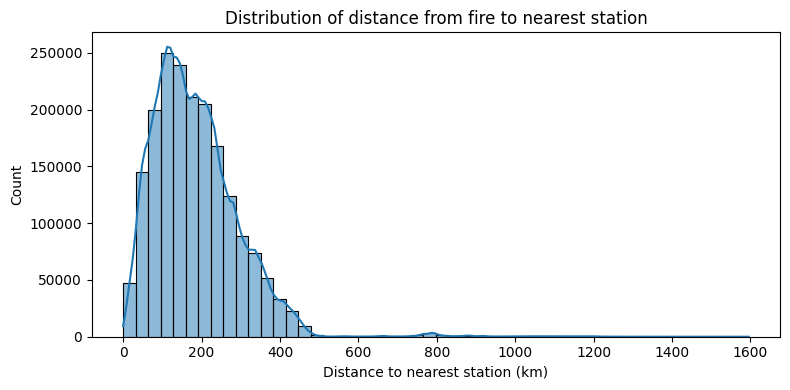

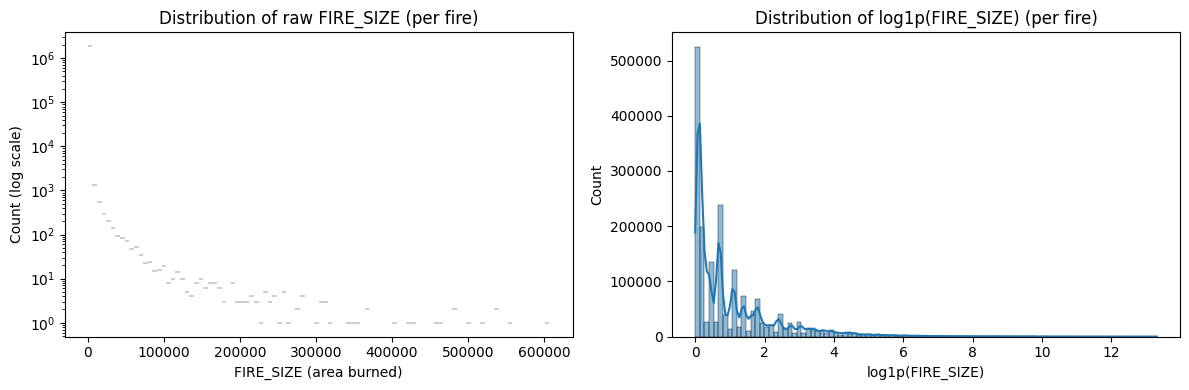

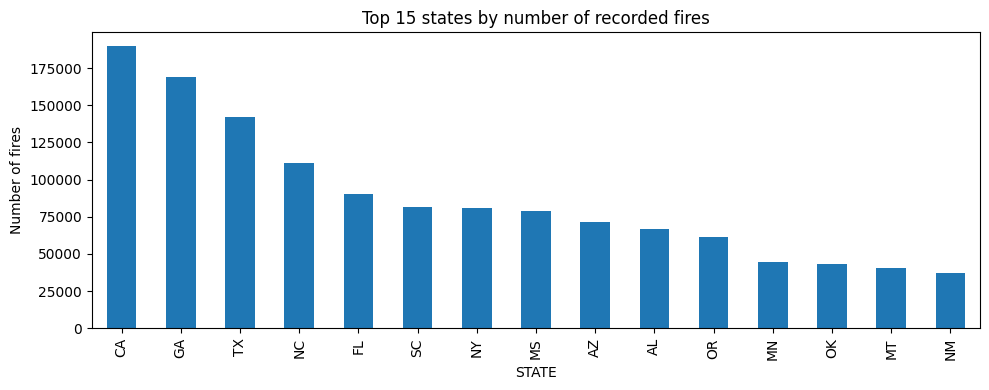

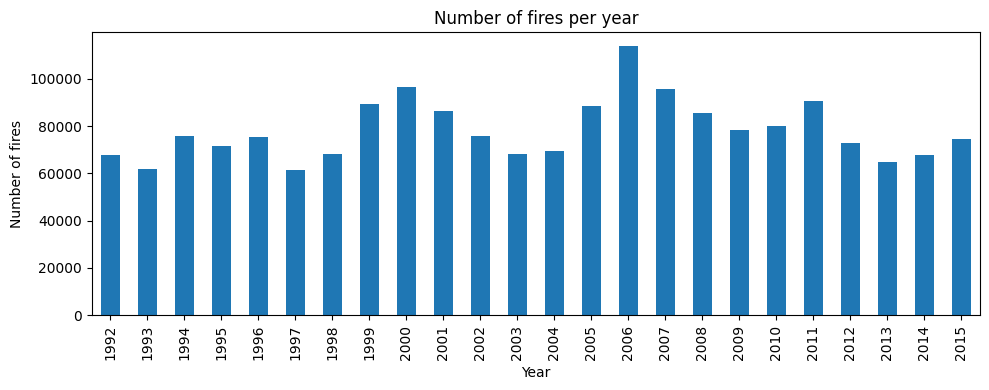

In [6]:
# ---- 0.1 EDA: distance to nearest station and burned area ----
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we have the station distance in km (computed in the previous cell)
assert 'dist_to_station_km' in fires.columns, 'dist_to_station_km missing; run the station mapping cell first.'

plt.figure(figsize=(8, 4))
sns.histplot(fires['dist_to_station_km'], bins=50, kde=True)
plt.xlabel('Distance to nearest station (km)')
plt.title('Distribution of distance from fire to nearest station')
plt.tight_layout()
plt.show()

# Raw area burned per fire
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(fires['FIRE_SIZE'], bins=100, log_scale=(False, True))
plt.xlabel('FIRE_SIZE (area burned)')
plt.ylabel('Count (log scale)')
plt.title('Distribution of raw FIRE_SIZE (per fire)')

# Log-transformed area per fire
plt.subplot(1, 2, 2)
log_fire_size = np.log1p(fires['FIRE_SIZE'])
sns.histplot(log_fire_size, bins=100, kde=True)
plt.xlabel('log1p(FIRE_SIZE)')
plt.title('Distribution of log1p(FIRE_SIZE) (per fire)')

plt.tight_layout()
plt.show()

# EDA: simple counts per state and over time
plt.figure(figsize=(10, 4))
fires['STATE'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 states by number of recorded fires')
plt.xlabel('STATE')
plt.ylabel('Number of fires')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
fires['date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Number of fires per year')
plt.xlabel('Year')
plt.ylabel('Number of fires')
plt.tight_layout()
plt.show()

In [7]:
# ---- 1.2 Aggregate to station–day ----

# Optionally: restrict to fires within a maximum distance of their assigned station

# Set this to None to keep all fires, or to a value in km (e.g., 400) to drop very distant matches.
max_fire_station_distance_km = None  # e.g., 400
fires_for_agg = fires.copy()
if max_fire_station_distance_km is not None:
    fires_for_agg = fires_for_agg[fires_for_agg['dist_to_station_km'] <= max_fire_station_distance_km].copy()
    print(f"Using {len(fires_for_agg):,} fires within {max_fire_station_distance_km} km of a station (out of {len(fires):,})")

# Basic daily targets per station
daily_agg = (
    fires_for_agg.groupby(['station_id', 'date'])
    .agg(
        n_fires=('FIRE_SIZE', 'size'),
        area_burned=('FIRE_SIZE', 'sum'),
        min_dist_km=('dist_to_station_km', 'min'),
        mean_dist_km=('dist_to_station_km', 'mean'),
    )
    .reset_index()
 )

# Cause counts per station–day (wide format)
cause_counts = (
    fires_for_agg.pivot_table(
        index=['station_id', 'date'],
        columns='STAT_CAUSE_CODE',
        values='FIRE_SIZE',  # any column, we just count
        aggfunc='count',
        fill_value=0,
    )
    .rename_axis(columns='cause_code')
)

# Make nicer column names: cause_1, cause_2, ...
cause_counts.columns = [f'cause_{int(c)}' for c in cause_counts.columns]
cause_counts = cause_counts.reset_index()

# Merge counts into daily_agg
fires_daily = daily_agg.merge(
    cause_counts, on=['station_id', 'date'], how='left',
).fillna(0)

fires_daily['any_fire'] = (fires_daily['n_fires'] > 0).astype(int)
fires_daily.head()

,station_id,date,n_fires,area_burned,min_dist_km,mean_dist_km,cause_1,cause_2,cause_3,cause_4,cause_5,cause_6,cause_7,cause_8,cause_9,cause_10,cause_11,cause_12,cause_13,any_fire
0,25563,1992-04-27,2,0.6,1088.703963,1089.427229,0,0,0,2,0,0,0,0,0,0,0,0,0,1
1,25563,1992-05-15,1,30.0,1545.583577,1545.583577,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,25563,1992-05-21,1,1.8,1109.410967,1109.410967,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,25563,1992-05-30,1,4.8,1023.593742,1023.593742,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,25563,1992-06-03,1,13.0,1000.697964,1000.697964,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [8]:
# ---- 1.2b Aggregate pruned fires to station–day ----
# For each distance cutoff, build a station–day table analogous to `fires_daily`.

fires_daily_by_cutoff = {}

for d, fires_subset in fires_pruned.items():
    # Optionally mirror the max_fire_station_distance_km filter logic if desired
    fires_for_agg_d = fires_subset.copy()
    if max_fire_station_distance_km is not None:
        fires_for_agg_d = fires_for_agg_d[
            fires_for_agg_d['dist_to_station_km'] <= max_fire_station_distance_km
        ].copy()

    if fires_for_agg_d.empty:
        print(f"Warning: no fires left after filtering for cutoff {d} km; skipping.")
        continue

    daily_agg_d = (
        fires_for_agg_d.groupby(['station_id', 'date'])
        .agg(
            n_fires=('FIRE_SIZE', 'size'),
            area_burned=('FIRE_SIZE', 'sum'),
            min_dist_km=('dist_to_station_km', 'min'),
            mean_dist_km=('dist_to_station_km', 'mean'),
        )
        .reset_index()
    )

    cause_counts_d = (
        fires_for_agg_d.pivot_table(
            index=['station_id', 'date'],
            columns='STAT_CAUSE_CODE',
            values='FIRE_SIZE',
            aggfunc='count',
            fill_value=0,
        )
        .rename_axis(columns='cause_code')
    )
    cause_counts_d.columns = [f'cause_{int(c)}' for c in cause_counts_d.columns]
    cause_counts_d = cause_counts_d.reset_index()

    fires_daily_d = daily_agg_d.merge(
        cause_counts_d, on=['station_id', 'date'], how='left'
    ).fillna(0)
    fires_daily_d['any_fire'] = (fires_daily_d['n_fires'] > 0).astype(int)

    fires_daily_by_cutoff[d] = fires_daily_d
    print(
        f"Cutoff {d} km: {len(fires_daily_d):,} station-days with at least one fire event (post-aggregation)"
    )

# For backward compatibility, keep `fires_daily` as the unpruned (d=0) version if not already
if 0 in fires_daily_by_cutoff:
    fires_daily = fires_daily_by_cutoff[0]


Cutoff 100 km: 127,079 station-days with at least one fire event (post-aggregation)
Cutoff 200 km: 197,473 station-days with at least one fire event (post-aggregation)
Cutoff 400 km: 245,891 station-days with at least one fire event (post-aggregation)
Cutoff 0 km: 253,106 station-days with at least one fire event (post-aggregation)


In [9]:
# ---- 2.1 Load weather (station-based) ----
weather_path = DATA_DIR / 'us_daily_weather_1992_2015.parquet'
weather = pd.read_parquet(weather_path)

# Ensure date is datetime
weather['date'] = pd.to_datetime(weather['date'])

# Restrict to 1992–2015
weather = weather[
    (weather['date'].dt.year >= 1992) & (weather['date'].dt.year <= 2015)
]

# Load station metadata (cities.csv)
cities_path = DATA_DIR / 'cities.csv'
cities_df = pd.read_csv(cities_path)

# Merge state info into weather via station_id
weather = weather.merge(
    cities_df[['station_id', 'state']].drop_duplicates('station_id'),
    on='station_id',
    how='left',
)

weather = weather.rename(
    columns={
        'state': 'STATE',
        'avg_temp_c': 'tavg',
        'min_temp_c': 'tmin',
        'max_temp_c': 'tmax',
        'precipitation_mm': 'prcp_1d',  # explicit 1-day precipitation
        'avg_wind_speed_kmh': 'wspd',
        'avg_sea_level_pres_hpa': 'pres',
    }
)

weather.head()

,station_id,city_name,date,season,tavg,tmin,tmax,prcp_1d,snow_depth_mm,avg_wind_dir_deg,wspd,peak_wind_gust_kmh,pres,sunshine_total_min,STATE
0,72518,Albany,1992-01-01,Winter,-8.3,-15.0,1.1,0.0,0.0,NaN,1.4,13.0,1035.9,546.0,New York
1,72518,Albany,1992-01-02,Winter,NaN,-13.3,1.1,0.0,0.0,NaN,3.2,16.6,NaN,221.0,New York
2,72518,Albany,1992-01-03,Winter,1.8,-3.3,7.2,0.0,0.0,NaN,3.6,13.0,1027.5,227.0,New York
3,72518,Albany,1992-01-04,Winter,1.7,-3.3,3.9,9.4,0.0,NaN,10.1,25.9,1018.5,0.0,New York
4,72518,Albany,1992-01-05,Winter,3.6,1.7,5.6,0.0,0.0,336.0,15.1,38.9,1009.7,24.0,New York


In [10]:
# ---- 2.2 Aggregate station data to station–day ----
weather_daily = (
    weather.groupby(['station_id', 'date'])
    .agg(
        tavg=('tavg', 'mean'),
        tmin=('tmin', 'mean'),
        tmax=('tmax', 'mean'),
        prcp_1d=('prcp_1d', 'sum'),  # daily precip (1-day)
        wspd=('wspd', 'mean'),
        pres=('pres', 'mean'),
        STATE=('STATE', 'first'),
    )
    .reset_index()
)

weather_daily.head()

,station_id,date,tavg,tmin,tmax,prcp_1d,wspd,pres,STATE
0,70381,1992-01-01,3.8,3.3,4.4,13.2,31.7,NaN,Alaska
1,70381,1992-01-02,3.0,2.2,3.9,2.5,21.6,NaN,Alaska
2,70381,1992-01-03,2.3,0.0,3.9,2.0,12.2,NaN,Alaska
3,70381,1992-01-04,1.3,-0.6,3.3,0.0,11.2,NaN,Alaska
4,70381,1992-01-05,2.1,1.1,3.3,3.0,26.6,NaN,Alaska


In [11]:
# ---- 2.3 Add lagged weather features (per station) ----
def add_lagged_features(
    df,
    group_col,
    date_col,
    base_cols,
    windows=(3, 7, 30),
    shift=1,
):
    """
    For each base_col, compute rolling means or sums over given windows,
    then shift by `shift` days to avoid using same-day info.
    """
    df = df.sort_values([group_col, date_col]).copy()

    for col in base_cols:
        for w in windows:
            roll = (
                df.groupby(group_col)[col]
                .transform(lambda x: x.rolling(w, min_periods=1).mean())
            )
            df[f'{col}_mean_{w}'] = roll.shift(shift)

    # Cumulative precipitation over 7 and 30 days, based on 1-day precip
    for w in [7, 30]:
        roll = (
            df.groupby(group_col)['prcp_1d']
            .transform(lambda x: x.rolling(w, min_periods=1).sum())
        )
        df[f'prcp_1d_sum_{w}'] = roll.shift(shift)

    return df

weather_feat = weather_daily.copy()

# Impute any remaining NaNs before building lags (per station)
weather_feat = weather_feat.set_index('station_id')
weather_feat = weather_feat.groupby(level=0).ffill().bfill()
weather_feat = weather_feat.reset_index()

weather_feat['year'] = weather_feat['date'].dt.year
weather_feat['month'] = weather_feat['date'].dt.month
weather_feat['doy'] = weather_feat['date'].dt.dayofyear

base_cols = ['tavg', 'tmin', 'tmax', 'prcp_1d', 'wspd', 'pres']

weather_feat = add_lagged_features(
    weather_feat,
    group_col='station_id',
    date_col='date',
    base_cols=base_cols,
)

# Drop first few rows where lags are NaN (from shift)
weather_feat = weather_feat.dropna().reset_index(drop=True)

weather_feat.head()

,station_id,date,tavg,tmin,tmax,prcp_1d,wspd,pres,STATE,year,...,prcp_1d_mean_7,prcp_1d_mean_30,wspd_mean_3,wspd_mean_7,wspd_mean_30,pres_mean_3,pres_mean_7,pres_mean_30,prcp_1d_sum_7,prcp_1d_sum_30
0,70381,1992-01-02,3.0,2.2,3.9,2.5,21.6,1018.5,Alaska,1992,...,13.200,13.200,31.700000,31.700000,31.700000,1018.5,1018.5,1018.5,13.2,13.2
1,70381,1992-01-03,2.3,0.0,3.9,2.0,12.2,1018.5,Alaska,1992,...,7.850,7.850,26.650000,26.650000,26.650000,1018.5,1018.5,1018.5,15.7,15.7
2,70381,1992-01-04,1.3,-0.6,3.3,0.0,11.2,1018.5,Alaska,1992,...,5.900,5.900,21.833333,21.833333,21.833333,1018.5,1018.5,1018.5,17.7,17.7
3,70381,1992-01-05,2.1,1.1,3.3,3.0,26.6,1018.5,Alaska,1992,...,4.425,4.425,15.000000,19.175000,19.175000,1018.5,1018.5,1018.5,17.7,17.7
4,70381,1992-01-06,1.0,-0.6,2.2,0.5,10.8,1018.5,Alaska,1992,...,4.140,4.140,16.666667,20.660000,20.660000,1018.5,1018.5,1018.5,20.7,20.7


In [12]:
# ---- 3.1 Merge weather and fires on station + date + calendar / holiday features ----
data = weather_feat.merge(
    fires_daily, on=['station_id', 'date'], how='left'
)

# Replace NaNs in fire-related columns with 0
fire_cols = [c for c in data.columns if c.startswith('cause_')] + [
    'n_fires', 'area_burned', 'any_fire',
]
for c in fire_cols:
    if c in data.columns:
        data[c] = data[c].fillna(0)

# Transformed target for area
data['log_area_burned'] = np.log1p(data['area_burned'])

# Weekend indicator
data['is_weekend'] = data['date'].dt.weekday.isin([5, 6]).astype(int)

# US holidays
us_holidays = holidays.US()
data['holiday_name'] = data['date'].dt.date.map(us_holidays.get)
data['is_holiday'] = data['holiday_name'].notna().astype(int)
data['is_july4'] = (data['holiday_name'] == 'Independence Day').astype(int)

# Combined "weekend or holiday" flag (optional extra feature)
data['is_weekend_or_holiday'] = (
    (data['is_weekend'] == 1) | (data['is_holiday'] == 1)
).astype(int)

data.head()

,station_id,date,tavg,tmin,tmax,prcp_1d,wspd,pres,STATE,year,...,cause_11,cause_12,cause_13,any_fire,log_area_burned,is_weekend,holiday_name,is_holiday,is_july4,is_weekend_or_holiday
0,70381,1992-01-02,3.0,2.2,3.9,2.5,21.6,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,0,None,0,0,0
1,70381,1992-01-03,2.3,0.0,3.9,2.0,12.2,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,0,None,0,0,0
2,70381,1992-01-04,1.3,-0.6,3.3,0.0,11.2,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,1,None,0,0,1
3,70381,1992-01-05,2.1,1.1,3.3,3.0,26.6,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,1,None,0,0,1
4,70381,1992-01-06,1.0,-0.6,2.2,0.5,10.8,1018.5,Alaska,1992,...,0.0,0.0,0.0,0.0,0.0,0,None,0,0,0


In [13]:
# ---- 3.1b Build merged feature tables for each distance cutoff ----
# We reuse `weather_feat` and merge with each `fires_daily_d`.

merged_by_cutoff = {}

for d, fires_daily_d in fires_daily_by_cutoff.items():
    data_d = weather_feat.merge(
        fires_daily_d, on=['station_id', 'date'], how='left'
    )

    # Fire-related columns: cause_*, n_fires, area_burned, any_fire
    fire_cols_d = [c for c in data_d.columns if c.startswith('cause_')] + [
        'n_fires', 'area_burned', 'any_fire',
    ]
    for c in fire_cols_d:
        if c in data_d.columns:
            data_d[c] = data_d[c].fillna(0)

    data_d['log_area_burned'] = np.log1p(data_d.get('area_burned', 0))

    data_d['is_weekend'] = data_d['date'].dt.weekday.isin([5, 6]).astype(int)
    us_holidays = holidays.US()
    data_d['holiday_name'] = data_d['date'].dt.date.map(us_holidays.get)
    data_d['is_holiday'] = data_d['holiday_name'].notna().astype(int)
    data_d['is_july4'] = (data_d['holiday_name'] == 'Independence Day').astype(int)
    data_d['is_weekend_or_holiday'] = (
        (data_d['is_weekend'] == 1) | (data_d['is_holiday'] == 1)
    ).astype(int)

    merged_by_cutoff[d] = data_d
    print(f"Built merged weather+fire table for cutoff {d} km with {len(data_d):,} rows")

# For backward compatibility, keep `data` as the unpruned version (d=0)
if 0 in merged_by_cutoff:
    data = merged_by_cutoff[0]


Built merged weather+fire table for cutoff 100 km with 424,165 rows
Built merged weather+fire table for cutoff 200 km with 424,165 rows
Built merged weather+fire table for cutoff 400 km with 424,165 rows
Built merged weather+fire table for cutoff 0 km with 424,165 rows


In [14]:
# ---- 4.1 Encode STATE and station_id ----
le_state = LabelEncoder()
data['STATE_LE'] = le_state.fit_transform(
    data['STATE'].fillna('UNK').astype(str)
 )

le_station = LabelEncoder()
data['station_LE'] = le_station.fit_transform(
    data['station_id'].astype(str)
 )

# ---- 4.2 Final feature list (excluding targets) ----
# Conservative pruning of highly correlated helpers:
pruned_cols = {
    'doy',              # keep month as the main seasonal indicator
    'prcp_1d_mean_7',   # keep prcp_1d_sum_7
    'prcp_1d_mean_30',  # keep prcp_1d_sum_30
}

exclude_cols = {
    'n_fires',
    'any_fire',
    'area_burned',
    'log_area_burned',
    'STATE',
    'station_id',
    'date',
    'holiday_name',  # drop string column so all features are numeric
} | set([c for c in data.columns if c.startswith('cause_')]) | pruned_cols

feature_cols = [c for c in data.columns if c not in exclude_cols]
len(feature_cols), feature_cols[:10]

(34,
 ['tavg',
  'tmin',
  'tmax',
  'prcp_1d',
  'wspd',
  'pres',
  'year',
  'month',
  'tavg_mean_3',
  'tavg_mean_7'])

In [15]:
# ---- 4.3 Build feature/target sets per cutoff ----
# We reuse the same `feature_cols` definition for all pruned datasets.

features_by_cutoff = {}
targets_by_cutoff = {}

for d, data_d in merged_by_cutoff.items():
    # Encode STATE and station_id using the same encoders as the base data
    data_d = data_d.copy()
    data_d['STATE_LE'] = le_state.transform(
        data_d['STATE'].fillna('UNK').astype(str)
    )
    data_d['station_LE'] = le_station.transform(
        data_d['station_id'].astype(str)
    )

    X_d = data_d[feature_cols]
    y_count_d = data_d['n_fires']
    y_bin_d = data_d['any_fire']
    y_log_area_d = data_d['log_area_burned']

    features_by_cutoff[d] = X_d
    targets_by_cutoff[d] = {
        'n_fires': y_count_d,
        'any_fire': y_bin_d,
        'log_area_burned': y_log_area_d,
        'year': data_d['year'],
    }

    print(
        f"Prepared feature/target matrices for cutoff {d} km: X shape = {X_d.shape}"
    )


Prepared feature/target matrices for cutoff 100 km: X shape = (424165, 34)
Prepared feature/target matrices for cutoff 200 km: X shape = (424165, 34)
Prepared feature/target matrices for cutoff 400 km: X shape = (424165, 34)
Prepared feature/target matrices for cutoff 0 km: X shape = (424165, 34)


Top 20 strongest absolute correlations among features:
tavg_mean_3            tavg_mean_7              0.974308
tavg_mean_7            tavg_mean_3              0.974308
tmin_mean_3            tmin_mean_7              0.968918
tmin_mean_7            tmin_mean_3              0.968918
tmax_mean_3            tmax_mean_7              0.961028
tmax_mean_7            tmax_mean_3              0.961028
tmax_mean_30           tmin_mean_30             0.957204
tmin_mean_30           tmax_mean_30             0.957204
tavg_mean_7            tavg_mean_30             0.953332
tavg_mean_30           tavg_mean_7              0.953332
tmin_mean_30           tmin_mean_7              0.947035
tmin_mean_7            tmin_mean_30             0.947035
is_weekend             is_weekend_or_holiday    0.943415
is_weekend_or_holiday  is_weekend               0.943415
tmax_mean_7            tmin_mean_7              0.939463
tmin_mean_7            tmax_mean_7              0.939463
tmax_mean_30           tmax_mean_

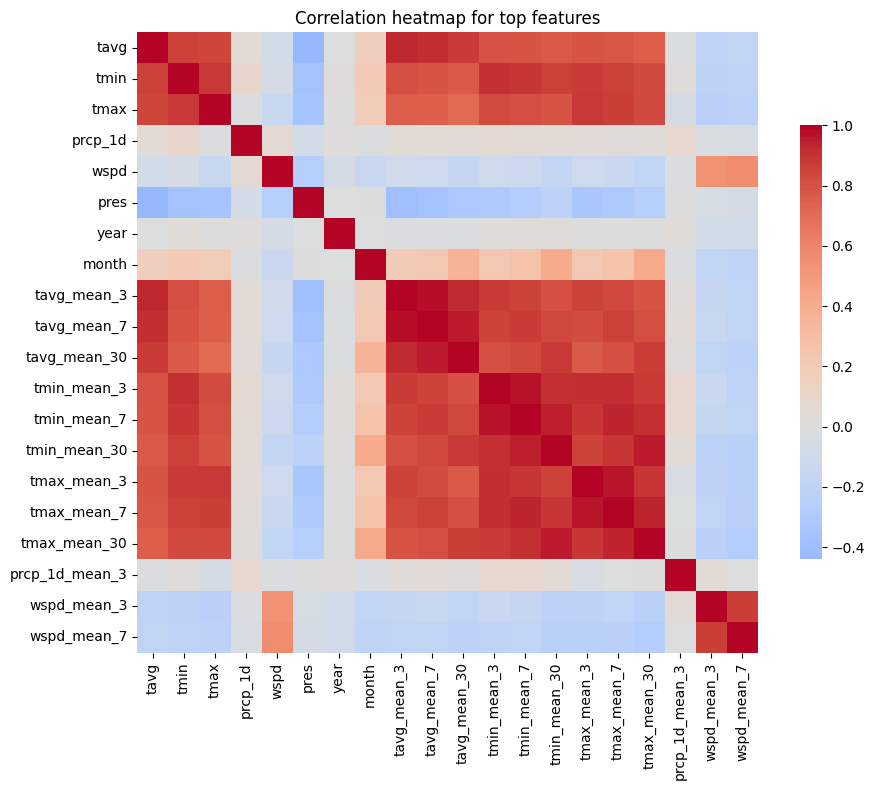

In [16]:
# Use only the feature columns and drop any remaining NaNs
corr_features = data[feature_cols].copy().dropna()

# Compute Pearson correlation
corr_matrix = corr_features.corr()

# Quick summary: show the top 20 most correlated pairs (by absolute value, excluding self)
corr_unstacked = (
    corr_matrix.abs()
    .where(~np.eye(corr_matrix.shape[0], dtype=bool))  # mask diagonal
    .unstack()
    .dropna()
    .sort_values(ascending=False)
)

print("Top 20 strongest absolute correlations among features:")
print(corr_unstacked.head(20))

# Optional: visualize a smaller subset (e.g., the most important features)
top_feats = feature_importance_area.sort_values(
    "importance", ascending=False
)["feature"].head(20).tolist() if "feature_importance_area" in globals() else feature_cols[:20]

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix.loc[top_feats, top_feats],
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.7},
)
plt.title("Correlation heatmap for top features")
plt.tight_layout()
plt.show()

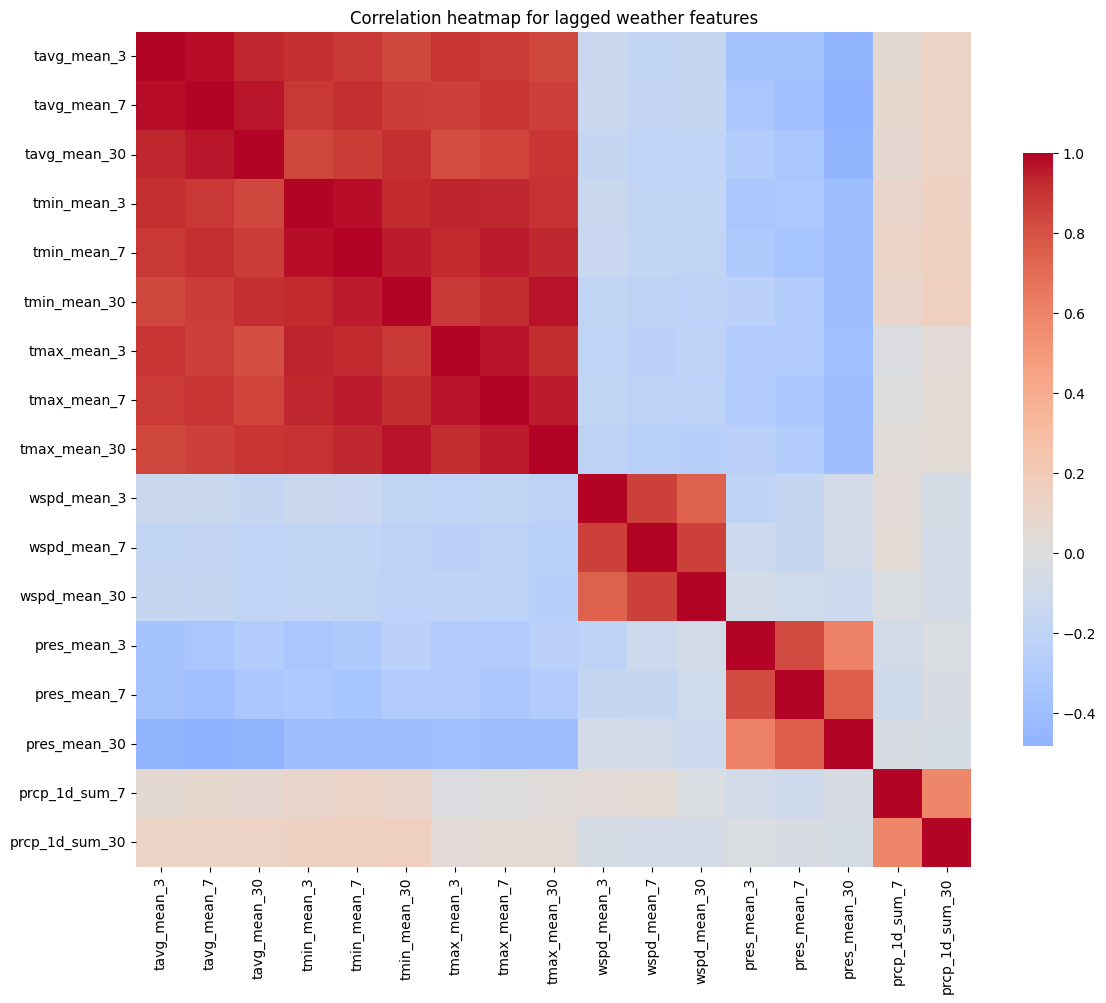

In [17]:
# ---- X.2 Correlation among weather lag features ----
lag_cols = [c for c in feature_cols if any(
    key in c for key in ["tavg_mean", "tmin_mean", "tmax_mean", "prcp_1d_sum", "wspd_mean", "pres_mean"]
)]

corr_lags = data[lag_cols].copy().dropna().corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_lags,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.7},
)
plt.title("Correlation heatmap for lagged weather features")
plt.tight_layout()
plt.show()

In [18]:
# ---- 5.1 Train / test split by year ----
train_year_cutoff = 2011
train_mask = data['year'] < train_year_cutoff
test_mask = ~train_mask

X_train = data.loc[train_mask, feature_cols]
X_test = data.loc[test_mask, feature_cols]

y_train_count = data.loc[train_mask, 'n_fires']
y_test_count = data.loc[test_mask, 'n_fires']

y_train_bin = data.loc[train_mask, 'any_fire']
y_test_bin = data.loc[test_mask, 'any_fire']

y_train_log_area = data.loc[train_mask, 'log_area_burned']
y_test_log_area = data.loc[test_mask, 'log_area_burned']

In [19]:
# ---- 5.2 Train models for each distance cutoff ----
# We will reuse the same LightGBM hyperparameters and year-based split.

results_by_cutoff = {}

for d in sorted(features_by_cutoff.keys()):
    print("\n" + "=" * 80)
    print(f"Training models for distance cutoff: {d} km")
    print("=" * 80)

    X_d = features_by_cutoff[d]
    tgt = targets_by_cutoff[d]

    year_d = tgt['year']
    train_mask_d = year_d < train_year_cutoff
    test_mask_d = ~train_mask_d

    X_train_d = X_d.loc[train_mask_d]
    X_test_d = X_d.loc[test_mask_d]

    y_train_count_d = tgt['n_fires'].loc[train_mask_d]
    y_test_count_d = tgt['n_fires'].loc[test_mask_d]

    y_train_bin_d = tgt['any_fire'].loc[train_mask_d]
    y_test_bin_d = tgt['any_fire'].loc[test_mask_d]

    y_train_log_area_d = tgt['log_area_burned'].loc[train_mask_d]
    y_test_log_area_d = tgt['log_area_burned'].loc[test_mask_d]

    # Count model
    lgb_train_d = lgb.Dataset(X_train_d, label=y_train_count_d)
    lgb_valid_d = lgb.Dataset(X_test_d, label=y_test_count_d)

    params_count = {
    'objective': 'poisson',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'metric': 'rmse',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed': RANDOM_STATE,
}


    model_count_d = lgb.train(
        params_count,
        lgb_train_d,
        num_boost_round=2000,
        valid_sets=[lgb_valid_d],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200),
        ],
    )
    pred_count_d = model_count_d.predict(
        X_test_d, num_iteration=model_count_d.best_iteration
    )
    rmse_count_d = np.sqrt(mean_squared_error(y_test_count_d, pred_count_d))

    # Binary any-fire model
    lgb_train_bin_d = lgb.Dataset(X_train_d, label=y_train_bin_d)
    lgb_valid_bin_d = lgb.Dataset(X_test_d, label=y_test_bin_d)

    params_bin = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "metric": "auc",
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "seed": RANDOM_STATE,
}

    model_bin_d = lgb.train(
        params_bin,
        lgb_train_bin_d,
        num_boost_round=2000,
        valid_sets=[lgb_valid_bin_d],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200),
        ],
    )
    prob_any_fire_d = model_bin_d.predict(
        X_test_d, num_iteration=model_bin_d.best_iteration
    )
    auc_any_fire_d = roc_auc_score(y_test_bin_d, prob_any_fire_d)

    # Area model
    lgb_train_area_d = lgb.Dataset(X_train_d, label=y_train_log_area_d)
    lgb_valid_area_d = lgb.Dataset(X_test_d, label=y_test_log_area_d)

    params_area = {
    "objective": "regression",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "metric": "rmse",
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "seed": RANDOM_STATE,
}

    model_area_d = lgb.train(
        params_area,
        lgb_train_area_d,
        num_boost_round=2000,
        valid_sets=[lgb_valid_area_d],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200),
        ],
    )
    pred_log_area_d = model_area_d.predict(
        X_test_d, num_iteration=model_area_d.best_iteration
    )
    rmse_log_area_d = np.sqrt(
        mean_squared_error(y_test_log_area_d, pred_log_area_d)
    )

    results_by_cutoff[d] = {
        'rmse_count': rmse_count_d,
        'auc_any_fire': auc_any_fire_d,
        'rmse_log_area': rmse_log_area_d,
    }

    print(f"Cutoff {d} km -> Count RMSE: {rmse_count_d:.3f}")
    print(f"Cutoff {d} km -> AUC(any_fire): {auc_any_fire_d:.3f}")
    print(f"Cutoff {d} km -> RMSE(log1p area): {rmse_log_area_d:.3f}")



Training models for distance cutoff: 0 km
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6386
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 34
[LightGBM] [Info] Start training from score 1.392832
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 5.0095
[400]	valid_0's rmse: 4.92041
[600]	valid_0's rmse: 4.88792
[800]	valid_0's rmse: 4.87352
[1000]	valid_0's rmse: 4.8642
[1200]	valid_0's rmse: 4.8567
Early stopping, best iteration is:
[1194]	valid_0's rmse: 4.85651
[LightGBM] [Info] Number of positive: 157497, number of negative: 177930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6386
[LightGBM] [Info] Number of data point

In [20]:
# ---- 5.3 Summary of results ----
results_summary = pd.DataFrame.from_dict(
    results_by_cutoff, orient='index'
)
results_summary


,rmse_count,auc_any_fire,rmse_log_area
0,4.856507,1.0,1.071407
100,1.525009,1.0,0.657168
200,3.200387,1.0,0.911686
400,4.795640,1.0,1.058993


In [21]:
# print the results summary
print("\nSummary of results by distance cutoff (km):")
print(results_summary)


Summary of results by distance cutoff (km):
     rmse_count  auc_any_fire  rmse_log_area
0      4.856507           1.0       1.071407
100    1.525009           1.0       0.657168
200    3.200387           1.0       0.911686
400    4.795640           1.0       1.058993


In [22]:

# Sanity check: ensure no target columns are in feature_cols
bad_targets = {'n_fires', 'any_fire', 'area_burned', 'log_area_burned'}
bad_in_features = bad_targets.intersection(feature_cols)
print('Targets in feature_cols:', bad_in_features)
 
cause_in_features = [c for c in feature_cols if c.startswith('cause_')]
print('Cause columns in feature_cols (should be empty):', cause_in_features)



# Inspect distribution of predicted probabilities by label for one cutoff (e.g. 0 km)
d = 0  # change to 100, 200, 400 to inspect others

X_d = features_by_cutoff[d]
tgt = targets_by_cutoff[d]
year_d = tgt['year']
train_mask_d = year_d < train_year_cutoff
test_mask_d = ~train_mask_d

X_test_d = X_d.loc[test_mask_d]
y_test_bin_d = tgt['any_fire'].loc[test_mask_d]

# Recompute the binary model for this cutoff only, reusing params_bin
lgb_train_bin_d = lgb.Dataset(X_d.loc[train_mask_d], label=tgt['any_fire'].loc[train_mask_d])
lgb_valid_bin_d = lgb.Dataset(X_test_d, label=y_test_bin_d)
model_bin_d = lgb.train(
    params_bin,
    lgb_train_bin_d,
    num_boost_round=2000,
    valid_sets=[lgb_valid_bin_d],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=200)],
)
prob_any_fire_d = model_bin_d.predict(X_test_d, num_iteration=model_bin_d.best_iteration)

print('AUC for cutoff', d, ':', roc_auc_score(y_test_bin_d, prob_any_fire_d))

print('\nProbability summary for negative days (any_fire=0):')
print(pd.Series(prob_any_fire_d[y_test_bin_d == 0]).describe())

print('\nProbability summary for positive days (any_fire=1):')
print(pd.Series(prob_any_fire_d[y_test_bin_d == 1]).describe())

Targets in feature_cols: set()
Cause columns in feature_cols (should be empty): []
[LightGBM] [Info] Number of positive: 157497, number of negative: 177930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6386
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469542 -> initscore=-0.121984
[LightGBM] [Info] Start training from score -0.121984
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 1
AUC for cutoff 0 : 1.0

Probability summary for negative days (any_fire=0):
count    43601.000000
mean         0.438134
std          0.011685
min          0.424258
25%          0.429208
50%          0.433365
75%          0.443607
max          0.471280
dtype: float64

Probability summary for positive d

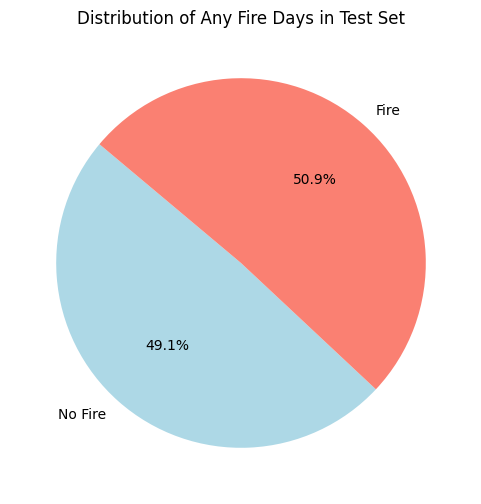

In [23]:
#show pie of days with any_fire=1 vs any_fire=0
labels = ['No Fire', 'Fire']
sizes = [len(y_test_bin_d) - y_test_bin_d.sum(), y_test_bin_d.sum()]
colors = ['lightblue', 'salmon']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Any Fire Days in Test Set')
plt.show()

In [24]:
# ---- 6.1 Count model (Poisson) ----
lgb_train = lgb.Dataset(X_train, label=y_train_count)
lgb_valid = lgb.Dataset(X_test, label=y_test_count)

params_count = {
    'objective': 'poisson',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'metric': 'rmse',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed': RANDOM_STATE,
}

model_count = lgb.train(
    params_count,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_valid],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)],
)

pred_count = model_count.predict(X_test, num_iteration=model_count.best_iteration)
rmse_count = np.sqrt(mean_squared_error(y_test_count, pred_count))

print(f'Count model RMSE: {rmse_count:.3f}')
print(f'Mean actual count in test: {y_test_count.mean():.3f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6386
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 34
[LightGBM] [Info] Start training from score 1.392832
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 5.11164
[200]	valid_0's rmse: 5.0095
[300]	valid_0's rmse: 4.95696
[400]	valid_0's rmse: 4.92041
[500]	valid_0's rmse: 4.90278
[600]	valid_0's rmse: 4.88792
[700]	valid_0's rmse: 4.87989
[800]	valid_0's rmse: 4.87352
[900]	valid_0's rmse: 4.86872
[1000]	valid_0's rmse: 4.8642
[1100]	valid_0's rmse: 4.86016
[1200]	valid_0's rmse: 4.8567
Early stopping, best iteration is:
[1194]	valid_0's rmse: 4.85651
Count model RMSE: 4.857
Mean actual count in test: 3.683


In [25]:
# ---- 6.2 Binary any-fire model (for AUC) ----
params_bin = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'metric': 'auc',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed': RANDOM_STATE,
}

lgb_train_bin = lgb.Dataset(X_train, label=y_train_bin)
lgb_valid_bin = lgb.Dataset(X_test, label=y_test_bin)

model_bin = lgb.train(
    params_bin,
    lgb_train_bin,
    num_boost_round=2000,
    valid_sets=[lgb_valid_bin],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)],
)

prob_any_fire = model_bin.predict(
    X_test, num_iteration=model_bin.best_iteration
)
auc_any_fire = roc_auc_score(y_test_bin, prob_any_fire)

print(f'AUC (any_fire): {auc_any_fire:.3f}')
print(f'Positive rate (fires on a day): {y_test_bin.mean():.3f}')

[LightGBM] [Info] Number of positive: 157497, number of negative: 177930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6386
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469542 -> initscore=-0.121984
[LightGBM] [Info] Start training from score -0.121984
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 1
Early stopping, best iteration is:
[2]	valid_0's auc: 1
AUC (any_fire): 1.000
Positive rate (fires on a day): 0.509


In [26]:
# ---- 7.1 Area model ----
params_area = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'metric': 'rmse',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed': RANDOM_STATE,
}

lgb_train_area = lgb.Dataset(X_train, label=y_train_log_area)
lgb_valid_area = lgb.Dataset(X_test, label=y_test_log_area)

model_area = lgb.train(
    params_area,
    lgb_train_area,
    num_boost_round=2000,
    valid_sets=[lgb_valid_area],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)],
)

pred_log_area = model_area.predict(
    X_test, num_iteration=model_area.best_iteration
)

rmse_log_area = np.sqrt(mean_squared_error(
    y_test_log_area, pred_log_area
))
r2_log_area = r2_score(y_test_log_area, pred_log_area)

print(f'Area model RMSE (log1p): {rmse_log_area:.3f}')
print(f'Area model R^2 (log1p): {r2_log_area:.3f}')

# Baseline: predict mean log-area of train
baseline_log = np.full_like(y_test_log_area, y_train_log_area.mean())
baseline_rmse_log = np.sqrt(mean_squared_error(
    y_test_log_area, baseline_log
))
print(f'Baseline RMSE (log1p mean): {baseline_rmse_log:.3f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6386
[LightGBM] [Info] Number of data points in the train set: 335427, number of used features: 34
[LightGBM] [Info] Start training from score 1.190421
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.09658
[200]	valid_0's rmse: 1.08176
[300]	valid_0's rmse: 1.07776
[400]	valid_0's rmse: 1.07506
[500]	valid_0's rmse: 1.07358
[600]	valid_0's rmse: 1.07281
[700]	valid_0's rmse: 1.07248
[800]	valid_0's rmse: 1.07199
[900]	valid_0's rmse: 1.07157
[1000]	valid_0's rmse: 1.07202
Early stopping, best iteration is:
[933]	valid_0's rmse: 1.07141
Area model RMSE (log1p): 1.071
Area model R^2 (log1p): 0.701
Baseline RMSE (log1p mean): 1.959


In [27]:
# ---- 8.1 Prepare cause targets ----
cause_cols = [c for c in data.columns if c.startswith('cause_')]
len(cause_cols), cause_cols

# Keep only days with at least one fire
data_cause = data[data['n_fires'] > 0].copy()

# Proportions per cause
for c in cause_cols:
    data_cause[c + '_prop'] = data_cause[c] / data_cause['n_fires']

target_prop_cols = [c + '_prop' for c in cause_cols]

# Train/test split by year (same cutoff)
train_mask_cause = data_cause['year'] < train_year_cutoff
test_mask_cause = ~train_mask_cause

X_train_cause = data_cause.loc[train_mask_cause, feature_cols]
X_test_cause = data_cause.loc[test_mask_cause, feature_cols]

Y_train_cause = data_cause.loc[train_mask_cause, target_prop_cols].values
Y_test_cause = data_cause.loc[test_mask_cause, target_prop_cols].values

In [28]:
# ---- 8.2 Multi-output regression for cause proportions ----
base_reg = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    num_leaves=64,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
)

multi_reg = MultiOutputRegressor(base_reg)
multi_reg.fit(X_train_cause, Y_train_cause)

Y_pred_cause = multi_reg.predict(X_test_cause)

# Ensure non-negative and normalize to sum to 1
Y_pred_cause = np.clip(Y_pred_cause, 0, None)
row_sums = Y_pred_cause.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
Y_pred_cause = Y_pred_cause / row_sums

# ---- 8.3 Metrics: MSE of proportions and cross-entropy per fire ----
mse_props = mean_squared_error(Y_test_cause.reshape(-1), Y_pred_cause.reshape(-1))
print(f'MSE on cause proportions: {mse_props:.5f}')

eps = 1e-12
ce_per_day = -np.sum(Y_test_cause * np.log(Y_pred_cause + eps), axis=1)
ce_mean = ce_per_day.mean()
print(f'Mean cross-entropy (per day, per fire): {ce_mean:.3f}')

# Baseline: always predict global average cause distribution (from train)
global_dist = Y_train_cause.sum(axis=0)
global_dist = global_dist / global_dist.sum()

baseline_pred = np.tile(global_dist, (Y_test_cause.shape[0], 1))
ce_baseline = -np.sum(Y_test_cause * np.log(baseline_pred + eps), axis=1).mean()
mse_baseline = mean_squared_error(
    Y_test_cause.reshape(-1), baseline_pred.reshape(-1)
)

print(f'Baseline CE: {ce_baseline:.3f}')
print(f'Baseline MSE: {mse_baseline:.5f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6336
[LightGBM] [Info] Number of data points in the train set: 157497, number of used features: 34
[LightGBM] [Info] Start training from score 0.105416
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6336
[LightGBM] [Info] Number of data points in the train set: 157497, number of used features: 34
[LightGBM] [Info] Start training from score 0.080617
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6336
[LightGBM] [Info] Number of data points in the train set: 157497, number of used features: 34
[LightGBM] [Info] Start 

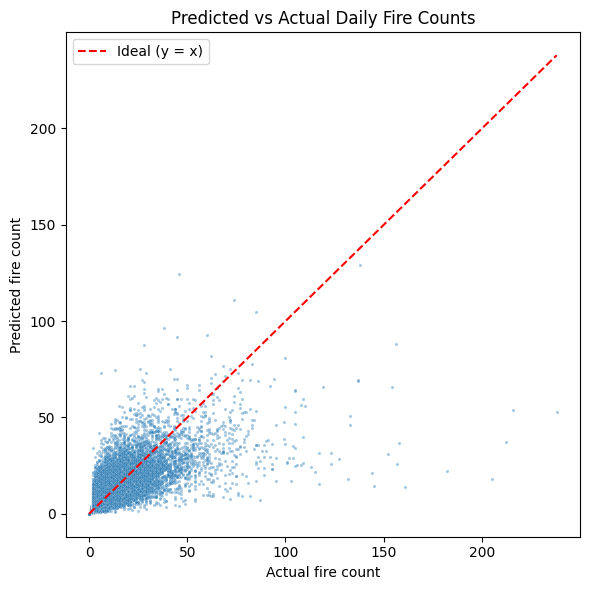

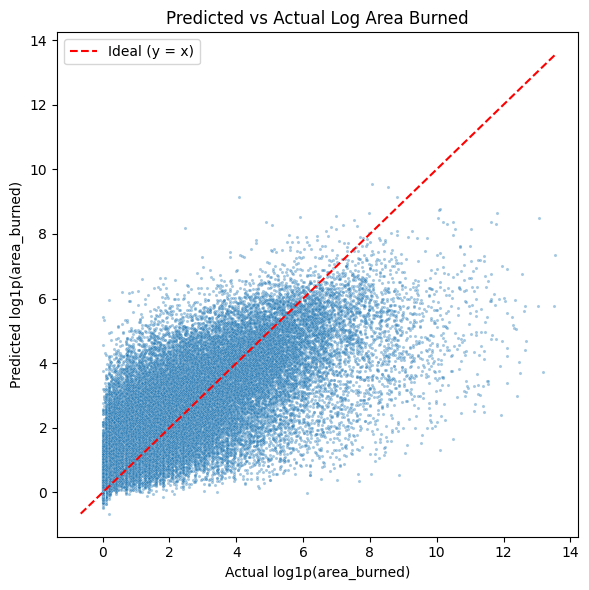

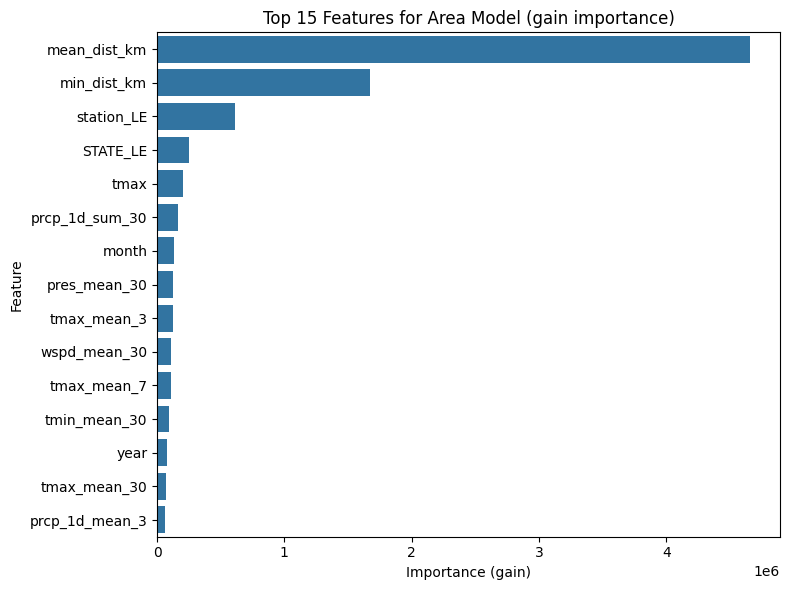

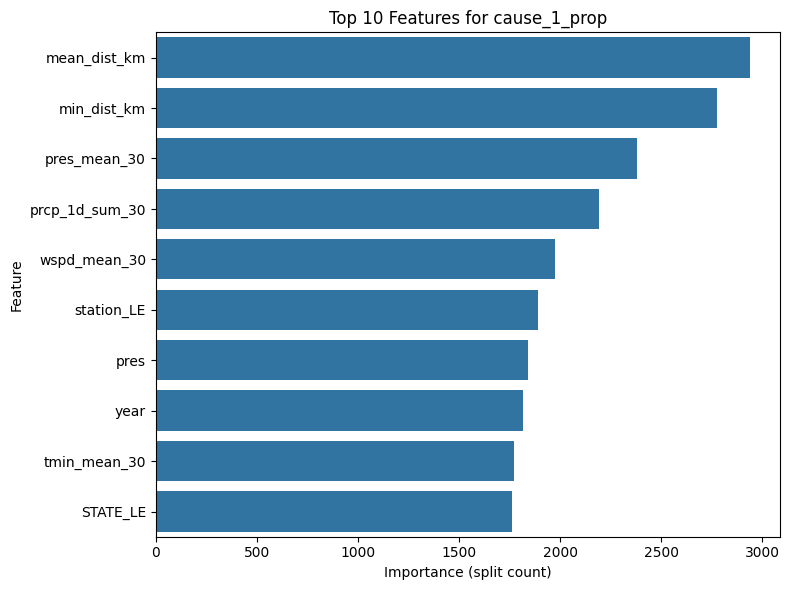

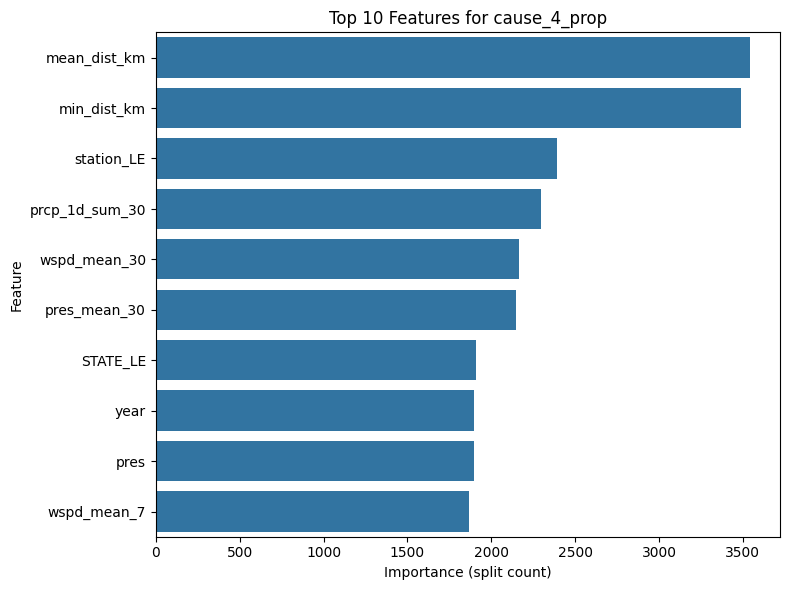

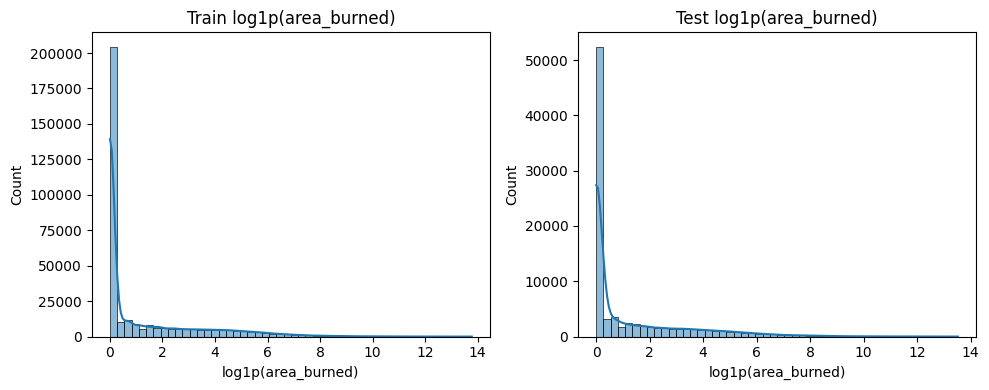

Train log-area:
count    335427.000000
mean          1.190421
std           1.970460
min           0.000000
25%           0.000000
50%           0.000000
75%           1.791759
max          13.782257
Name: log_area_burned, dtype: float64

Test log-area:
count    88738.000000
mean         1.193203
std          1.959292
min          0.000000
25%          0.000000
50%          0.029559
75%          1.791759
max         13.528744
Name: log_area_burned, dtype: float64


In [29]:
# ---- 9.1 Predicted vs Actual fire counts ----
# Assumes y_test_count and pred_count are available from earlier cells
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_count, y=pred_count, s=5, alpha=0.4)
max_val = max(y_test_count.max(), pred_count.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal (y = x)')
plt.xlabel('Actual fire count')
plt.ylabel('Predicted fire count')
plt.title('Predicted vs Actual Daily Fire Counts')
plt.legend()
plt.tight_layout()
plt.show()

# ---- 9.2 Predicted vs Actual log area burned ----
# Assumes y_test_log_area and pred_log_area are available
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_log_area, y=pred_log_area, s=5, alpha=0.4)
min_val = min(y_test_log_area.min(), pred_log_area.min())
max_val = max(y_test_log_area.max(), pred_log_area.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y = x)')
plt.xlabel('Actual log1p(area_burned)')
plt.ylabel('Predicted log1p(area_burned)')
plt.title('Predicted vs Actual Log Area Burned')
plt.legend()
plt.tight_layout()
plt.show()

# ---- 9.3 Feature importance for area model ----
# Use LightGBM's built-in feature importance for model_area
importances_area = model_area.feature_importance(importance_type='gain')
feature_importance_area = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances_area,
})
feature_importance_area = feature_importance_area.sort_values('importance', ascending=False)
top_n = 15
top_features_area = feature_importance_area.head(top_n)

plt.figure(figsize=(8, 6))
sns.barplot(data=top_features_area, x='importance', y='feature', orient='h')
plt.title(f'Top {top_n} Features for Area Model (gain importance)')
plt.xlabel('Importance (gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ---- 9.4 Feature importance for specific causes (cause_1_prop and cause_4_prop) ----
# Extract individual regressors from multi_reg
# Assumes target_prop_cols corresponds to order of outputs in multi_reg
cause_names = ['cause_1_prop', 'cause_4_prop']
for cause_name in cause_names:
    if cause_name not in target_prop_cols:
        print(f"Warning: {cause_name} not found in target_prop_cols; skipping.")
        continue

    idx = target_prop_cols.index(cause_name)
    reg = multi_reg.estimators_[idx]  # lightgbm.LGBMRegressor instance

    fi = reg.feature_importances_
    fi_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': fi,
    }).sort_values('importance', ascending=False)
    top_k = 10
    top_fi = fi_df.head(top_k)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=top_fi, x='importance', y='feature', orient='h')
    plt.title(f'Top {top_k} Features for {cause_name}')
    plt.xlabel('Importance (split count)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# ---- 9.5 Distributions of log area burned ----
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(y_train_log_area, bins=50, kde=True)
plt.title('Train log1p(area_burned)')
plt.xlabel('log1p(area_burned)')

plt.subplot(1, 2, 2)
sns.histplot(y_test_log_area, bins=50, kde=True)
plt.title('Test log1p(area_burned)')
plt.xlabel('log1p(area_burned)')

plt.tight_layout()
plt.show()

print('Train log-area:')
print(y_train_log_area.describe())
print('\nTest log-area:')
print(y_test_log_area.describe())

   cutoff_km  rmse_count  auc_any_fire  rmse_log_area
0          0    4.856507           1.0       1.071407
1        100    1.525009           1.0       0.657168
2        200    3.200387           1.0       0.911686
3        400    4.795640           1.0       1.058993


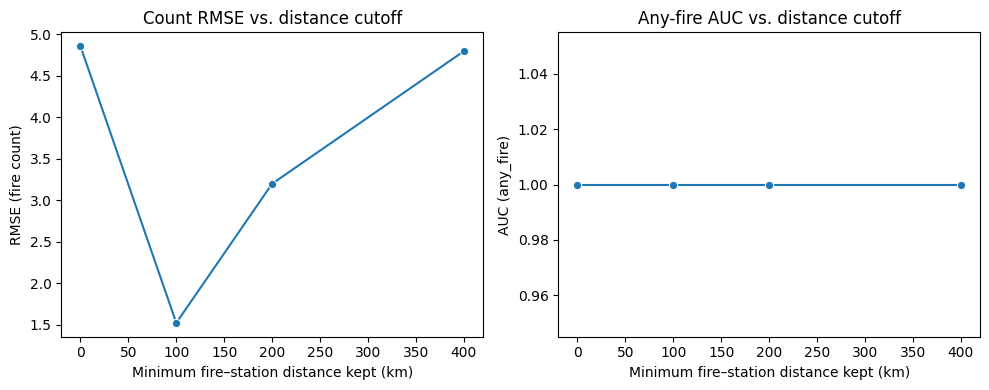

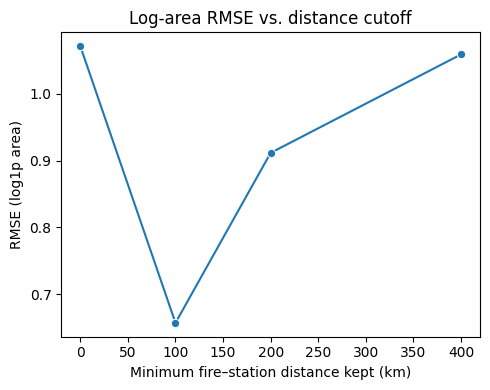

In [30]:
# ---- 9.6 Visualize fitness vs. distance cutoff ----
# Build a compact DataFrame of the summary metrics and plot vs cutoff.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

metrics_rows = []
for d, res in results_by_cutoff.items():
    metrics_rows.append({
        'cutoff_km': d,
        'rmse_count': res['rmse_count'],
        'auc_any_fire': res['auc_any_fire'],
        'rmse_log_area': res['rmse_log_area'],
    })

metrics_df = pd.DataFrame(metrics_rows).sort_values('cutoff_km')
print(metrics_df)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.lineplot(data=metrics_df, x='cutoff_km', y='rmse_count', marker='o')
plt.title('Count RMSE vs. distance cutoff')
plt.xlabel('Minimum fire–station distance kept (km)')
plt.ylabel('RMSE (fire count)')

plt.subplot(1, 2, 2)
sns.lineplot(data=metrics_df, x='cutoff_km', y='auc_any_fire', marker='o')
plt.title('Any-fire AUC vs. distance cutoff')
plt.xlabel('Minimum fire–station distance kept (km)')
plt.ylabel('AUC (any_fire)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.lineplot(data=metrics_df, x='cutoff_km', y='rmse_log_area', marker='o')
plt.title('Log-area RMSE vs. distance cutoff')
plt.xlabel('Minimum fire–station distance kept (km)')
plt.ylabel('RMSE (log1p area)')
plt.tight_layout()
plt.show()

# Feature and target glossary


This section summarizes the main engineered features and targets used in this notebook.



## Identifiers and time fields


- `station_id`: ID of the nearest weather station associated with each fire and each daily weather record.

- `STATE`: Two-letter US state abbreviation for the station.

- `date`: Calendar date (day-level granularity) for each station-day.

- `year`, `month`, `doy`: Calendar year, month (1–12), and day-of-year (1–366) derived from `date`.



## Weather features (daily aggregates)



Base daily weather variables aggregated per station and date:



- `tavg`: Mean daily temperature (°C).

- `tmin`: Minimum daily temperature (°C).

- `tmax`: Maximum daily temperature (°C).

- `prcp_1d`: Total daily precipitation (mm) for that day.

- `wspd`: Average daily wind speed (km/h).

- `pres`: Average daily sea-level pressure (hPa).



## Lagged and windowed weather features



To avoid look-ahead bias, rolling features are computed within each station, then shifted by 1 day so only **past** weather is used to predict fires on a given day.



For each base column in `[tavg, tmin, tmax, prcp_1d, wspd, pres]` and for window sizes 3, 7, and 30 days:



- `<col>_mean_3`, `<col>_mean_7`, `<col>_mean_30`  

  Rolling mean of the last 3, 7, or 30 days of that variable, shifted by 1 day.



For precipitation specifically:



- `prcp_1d_sum_7`, `prcp_1d_sum_30`  

  Rolling sum of daily precipitation over the last 7 or 30 days (also shifted by 1 day).



These lags capture short- and medium-term weather patterns leading up to potential fires.



## Calendar and holiday features



- `is_weekend`: 1 if `date` is Saturday or Sunday, otherwise 0.

- `is_holiday`: 1 if the date is a US federal holiday (from the `holidays` library), otherwise 0.

- `is_july4`: 1 if the date is **Independence Day**, otherwise 0.  

  This is a proxy for increased fire risk driven by fireworks.

- `is_weekend_or_holiday`: 1 if either `is_weekend` or `is_holiday` is 1, otherwise 0.



These features capture human behavior patterns (weekends, holidays, July 4) that can influence ignition risk.



## Encoded identifiers



- `STATE_LE`: Integer label encoding of `STATE` (state-level categorical information).

- `station_LE`: Integer label encoding of `station_id` (station identity).



These are used as numeric proxies for location in the models.



## Fire activity targets and cause counts



Station-day fire aggregates:



- `n_fires`: Number of fires discovered on that station-day.

- `area_burned`: Sum of `FIRE_SIZE` (area burned) across all fires on that station-day.

- `any_fire`: Binary indicator equal to 1 if at least one fire occurred (`n_fires > 0`), 0 otherwise.



Cause-specific daily counts (from pivoting `STAT_CAUSE_CODE`):



- `cause_1`, `cause_2`, ..., `cause_k`: Count of fires on that day attributed to each cause code `k`.



For the cause-proportion model (only on days with fires):



- `cause_<k>_prop`: Proportion of fires on that day attributed to cause code `k`, i.e.  

  `cause_<k>_prop = cause_<k> / n_fires`.



These per-cause proportions are used as multi-output regression targets in the `multi_reg` LightGBM model.



## Transformed area target



- `log_area_burned`: `log1p(area_burned)`  

  A log-transform of total burned area to stabilize variance and reduce the impact of very large fires.  

  This is the target for the **area model** (`model_area`).



### Train/test targets used in models



- `y_train_count`, `y_test_count`: Training and test labels for the **count model** (predicting `n_fires`).

- `y_train_bin`, `y_test_bin`: Training and test labels for the **binary any-fire model** (predicting `any_fire`).

- `y_train_log_area`, `y_test_log_area`: Training and test labels for the **area model** (predicting `log_area_burned`).



Together, these features and targets allow the notebook to model:



1. How many fires occur on a given station-day.

2. Whether any fire occurs at all.

3. How much area burns (on a log scale).

4. How the mix of ignition causes varies with weather, calendar, and location.
